In [1]:
#!/usr/bin/env bash
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/Junting98/language_data/master/language_data.zip

!unzip language_data.zip
!rm language_data.zip
!pip install unidecode

--2023-04-05 20:18:23--  https://raw.githubusercontent.com/Junting98/language_data/master/language_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25976656 (25M) [application/zip]
Saving to: ‘language_data.zip’

language_data.zip   100%[===================>]  24.77M  --.-KB/s    in 0.06s   

2023-04-05 20:18:23 (407 MB/s) - ‘language_data.zip’ saved [25976656/25976656]

/bin/bash: unzip: command not found
Defaulting to user installation because normal site-packages is not writeable


In [2]:
# https://github.com/spro/char-rnn.pytorch

import unidecode
import string
import random
import time
import math
import torch


all_characters = string.printable
n_characters = len(all_characters)

def read_file(filename):
    file = unidecode.unidecode(open(filename).read())
    return file, len(file)

# Turning a string into a tensor

def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        try:
            tensor[c] = all_characters.index(string[c])
        except:
            continue
    return tensor

# Readable time elapsed

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)



In [3]:
# https://github.com/spro/char-rnn.pytorch

import torch
import os
import argparse

# from rnn.helpers import *
# from rnn.model import *

def generate(decoder, prime_str='A', predict_len=100, temperature=0.8, device=None):
    hidden = decoder.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str).unsqueeze(0).to(device)

    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
      _, hidden = decoder(prime_input[:,p], hidden)
        
    inp = prime_input[:,-1]
    
    for p in range(predict_len):
      output, hidden = decoder(inp, hidden)
      
      # Sample from the network as a multinomial distribution

      output_dist = output.data.view(-1).div(temperature).exp()
      top_i = torch.multinomial(output_dist, 1)[0]

      # Add predicted character to string and use as next input
      predicted_char = all_characters[top_i]
      predicted += predicted_char
      inp = char_tensor(predicted_char).unsqueeze(0).to(device)

    return predicted


# Generating Text with an RNN

In [4]:
import unidecode
import string
import random
import re
import time

import torch
import torch.nn as nn

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [5]:
# from rnn.model import RNN
# from rnn.helpers import time_since
# from rnn.generate import generate

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

## Data Processing

The file we are using is a plain text file. We turn any potential unicode characters into plain ASCII by using the `unidecode` package (which you can install via `pip` or `conda`).

In [7]:
all_characters = string.printable
n_characters = len(all_characters)

file_path = 'language_data/shakespeare.txt'
file = unidecode.unidecode(open(file_path).read())
file_len = len(file)
print('file_len =', file_len)

# we will leave the last 1/10th of text as test

split = int(0.9*file_len)
train_text = file[:split]
test_text = file[split:]

print('train len: ', len(train_text))
print('test len: ', len(test_text))

file_len = 1115394
train len:  1003854
test len:  111540


In [8]:
chunk_len = 200

def random_chunk(text):
    start_index = random.randint(0, len(text) - chunk_len)
    end_index = start_index + chunk_len + 1
    return text[start_index:end_index]

print(random_chunk(train_text))

e:
The sly slow hours shall not determinate
The dateless limit of thy dear exile;
The hopeless word of 'never to return'
Breathe I against thee, upon pain of life.

THOMAS MOWBRAY:
A heavy sentence, my


### Input and Target data

To make training samples out of the large string of text data, we will be splitting the text into chunks.

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [9]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string), requires_grad=True).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return tensor

The following function loads a batch of input and target tensors for training. Each sample comes from a random chunk of text. A sample input will consist of all characters *except the last*, while the target wil contain all characters *following the first*. For example: if random_chunk='abc', then input='ab' and target='bc'

In [10]:
def load_random_batch(text, chunk_len, batch_size):
    input_data = torch.zeros(batch_size, chunk_len).long().to(device)
    target = torch.zeros(batch_size, chunk_len).long().to(device)
    for i in range(batch_size):
        start_index = random.randint(0, len(text) - chunk_len - 1)
        end_index = start_index + chunk_len + 1
        chunk = text[start_index:end_index]
        input_data[i] = char_tensor(chunk[:-1])
        target[i] = char_tensor(chunk[1:])
    return input_data, target

# Implement model

Your RNN model will take as input the character for step $t_{-1}$ and output a prediction for the next character $t$. The model should consiste of three layers - a linear layer that encodes the input character into an embedded state, an RNN layer (which may itself have multiple layers) that operates on that embedded state and a hidden state, and a decoder layer that outputs the predicted character scores distribution.


You must implement your model in the `rnn/model.py` file. You should use a `nn.Embedding` object for the encoding layer, a RNN model like `nn.RNN` or `nn.LSTM`, and a `nn.Linear` layer for the final a predicted character score decoding layer.


**TODO:** Implement the model in RNN `rnn/model.py`

# Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.


Note that in the `evaluate` function, every time a prediction is made the outputs are divided by the "temperature" argument. Higher temperature values make actions more equally likely giving more "random" outputs. Lower temperature values (less than 1) high likelihood options contribute more. A temperature near 0 outputs only the most likely outputs.

You may check different temperature values yourself, but we have provided a default which should work well.

In [11]:
def evaluate(rnn, prime_str='A', predict_len=100, temperature=0.8):
    hidden = rnn.init_hidden(1, device=device)
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = rnn(prime_input[p].unsqueeze(0).to(device), hidden)
    inp = prime_input[-1]
    
    for p in range(predict_len):
        output, hidden = rnn(inp.unsqueeze(0).to(device), hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        top_i = torch.multinomial(output_dist, 1)[0]
        
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
        predicted += predicted_char
        inp = char_tensor(predicted_char)

    return predicted

In [12]:
import torch
import torch.nn as nn

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, model_type="rnn", n_layers=1):
        super(RNN, self).__init__()

        self.model_type = model_type
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers

        self.embedding = nn.Embedding(input_size, hidden_size)

        self.linear = nn.Linear(hidden_size, output_size)
        
        self.rnn = nn.RNN(hidden_size, hidden_size, n_layers)
        self.lstm = nn.LSTM(hidden_size, hidden_size, n_layers)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)

    def forward(self, input, hidden):

        embedded_input = self.embedding(input)

        if self.model_type == "rnn":
          output, hidden = self.rnn(embedded_input.view(self.n_layers,input.size(0),-1), hidden)
        elif self.model_type == "lstm":
          output, hidden = self.lstm(embedded_input.view(self.n_layers,input.size(0),-1), hidden)
        elif self.model_type == "gru":
          output, hidden = self.gru(embedded_input.view(self.n_layers,input.size(0),-1), hidden)

        output = self.linear(output)

        return output, hidden

    def init_hidden(self, batch_size, device=None):
      
        if self.model_type == "lstm":
            hidden=(torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device),
                    torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device))
        else:
          hidden = torch.zeros(self.n_layers, batch_size, self.hidden_size, device=device)

        return hidden


# Train RNN

In [13]:
def train(rnn, input, target, optimizer, criterion):
  
  stringlength,batch_size,loss  = input.size(1),input.size(0),0
  hidden = rnn.init_hidden(batch_size,device)
  
  rnn.zero_grad()

  for i in range(stringlength):
    output, hidden = rnn(input[:, i], hidden)

    loss += criterion(output.view(batch_size, -1), target[:,i])

  loss.backward()
  optimizer.step()
  sigma_loss = loss.item()
  average_loss = sigma_loss/batch_size

  return  average_loss


def eval_test(rnn, inp, target,criterion,batch_size=100):
    with torch.no_grad():
        hidden = rnn.init_hidden(batch_size, device=device)
        loss = 0
        for c in range(chunk_len):
            output, hidden = rnn(inp[:,c], hidden)
            loss += criterion(output.view(batch_size, -1), target[:,c])
    
    return loss.data.item() / chunk_len

### Train function

**TODO**: Fill in the train function. You should initialize a hidden layer representation using your RNN's `init_hidden` function, set the model gradients to zero, and loop over each time step (character) in the input tensor. For each time step compute the output of the of the RNN and compute the loss over the output and the corresponding ground truth time step in `target`. The loss should be averaged over all time steps. Lastly, call backward on the averaged loss and take an optimizer step.


In [16]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def complete(batch_size=100,n_epochs=1500,hidden_size = 100,n_layers = 1,learning_rate = 0.01,model_type = 'rnn',print_every = 100,plot_every = 100):

  model = RNN(n_characters, hidden_size, n_characters, model_type=model_type, n_layers=n_layers).to(device)

  rnn_optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  criterion = nn.CrossEntropyLoss()

  start = time.time()
  all_losses = []
  test_losses = []
  loss_avg = 0
  test_loss_avg = 0

  print("Training for %d epochs..." % n_epochs)
  for epoch in range(1, n_epochs + 1):
      loss = train(model, *load_random_batch(train_text, chunk_len, batch_size), rnn_optimizer, criterion)
      loss_avg += loss
      
      test_loss = eval_test(model, *load_random_batch(test_text, chunk_len, batch_size),criterion)
      test_loss_avg += test_loss

      if epoch % print_every == 0:
          print('[%s (%d %d%%) train loss: %.4f, test_loss: %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss, test_loss))
          print(generate(model, 'Wh', 100, device=device), '\n')

      if epoch % plot_every == 0:
          print(epoch)
          all_losses.append(loss_avg / plot_every)
          test_losses.append(test_loss_avg / plot_every)
          loss_avg = 0
          test_loss_avg = 0
  
  plt.figure()
  plt.plot(all_losses)
  plt.plot(test_losses, color='r')

  generated_text = evaluate(model, prime_str='Th', predict_len=1000)

  print("text generation for model type",model_type,"   ",generated_text)

  return model

Training for 1500 epochs...
 29s (100 6%) train loss: 3.7998, test_loss: 1.9724]
Whenild, by my gook now whatk go, there newerung
The tike of and it tart geem tach re desod wort. I hi 

100
 59s (200 13%) train loss: 3.4836, test_loss: 1.8930]
Whey doth the lay way hate and he sour songer, bise throne, his peap me;
Me to heards teld worth,
That 

200
 29s (300 20%) train loss: 3.3245, test_loss: 1.8252]
Who so the love the bewory to mine, would course potched of thein to little
Thee?

Bishall my sorrenut 

300
 59s (400 26%) train loss: 3.2634, test_loss: 1.8163]
What me?

AlTAUS:
Seeption rucked the servin come the hate abomforse to bricied
Ay, it.

POLIXENES:
Th 

400
 29s (500 33%) train loss: 3.2599, test_loss: 1.7758]
What he prought ended on like see in his fame,
To have a drantry early than thy pinits
Envelten
Of in  

500
 59s (600 40%) train loss: 3.2367, test_loss: 1.8069]
Where not
a leave him like thus more that an my lurdanand, when that I court air Luke sword a striced  


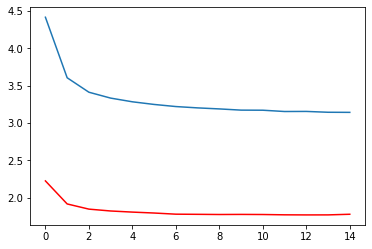

In [17]:
rnn1 = complete(model_type='rnn',hidden_size = 100,n_layers=1)

Training for 1500 epochs...
 30s (100 6%) train loss: 3.6550, test_loss: 1.8947]
Whand:
Jore bested of on the rencessett you, shall siness but this
or man the earping that chaver, for 

100
 0s (200 13%) train loss: 3.3513, test_loss: 1.8055]
Wharch as of her love wirfom they seathern's with wyour;
Cast not our too there to then how and prieft 

200
 31s (300 20%) train loss: 3.1516, test_loss: 1.7707]
Whyor dring; go's prom.

GLOUCIES:
What not all she fond and now to acpure.

RATHAMARUCIO:
And that th 

300
 1s (400 26%) train loss: 3.0994, test_loss: 1.7123]
Whally think way, the life.

FGORYOP:
Erew kind honourable stand show the marcy
down; fear, with me th 

400
 32s (500 33%) train loss: 3.0739, test_loss: 1.7266]
Where him.

DREY:
My proast here are of him!

VOLUMNIA:
I will be are excellented.

GLOUCESTER:
I do d 

500
 2s (600 40%) train loss: 3.0314, test_loss: 1.7573]
Whall comund dray
May in your sear away reppeace,
On him seck, afully you say batters,
Peraites, that  

60

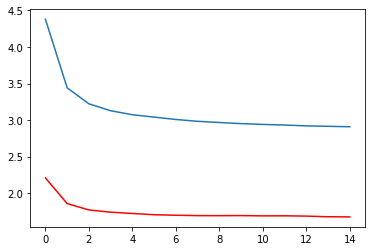

In [19]:
gru1 = complete(model_type='gru',hidden_size = 100,n_layers=1)

Training for 1500 epochs...
 30s (100 6%) train loss: 3.7684, test_loss: 1.9779]
Whay not wilve my part's your conour make math me not,
Whoul with you, what I throre, Forble him, the  

100
 1s (200 13%) train loss: 3.4177, test_loss: 1.8442]
Why sent we roved be dore;
Thee hat is this life, the lifowry elver,
And us that vice, so his swell;
H 

200
 32s (300 20%) train loss: 3.2687, test_loss: 1.7648]
What ie ruint me our deach to news,
When give to were not pacless that paspeced distach the mides the  

300
 2s (400 26%) train loss: 3.1006, test_loss: 1.7331]
Which mist the ary the better for you hath sheloo,
A becon they know; and trisirnes them in the gond o 

400
 33s (500 33%) train loss: 3.1317, test_loss: 1.6936]
Whose she shall I there love you thee.

ISABELLA:
And, part the hearted sent. That cores upon thy such 

500
 4s (600 40%) train loss: 3.0418, test_loss: 1.7074]
What thy love to thee, wels.

MENENIUS:
What with end! That were of her tite,
You care of doth as our  

60

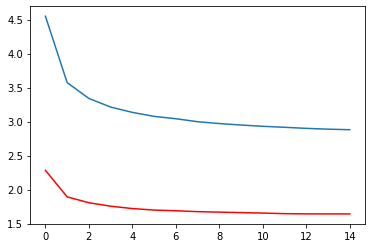

In [21]:
lstm1 = complete(model_type='lstm',hidden_size = 100,n_layers=1)

In [22]:
print(evaluate(rnn1, prime_str='Th', predict_len=1000))

Thif heart and ratis,
Whose
But surestle doth his law:
Between
his vap
That now!
For live were for you? must show you, and her chance,
The will with his intangers,
And well: your can have is it.

VALUE:

First Citizen:
He may unstry in us,
To most begur.

ISABELLA:
Good old by your blest own and them by cheeks belightly; and rated me of my blood
That is sun
And have and have
Behod and rights,
The priad of my mother of rescied, the nets of the son have the soon mesters stay so love hunst'rth. Father with this were in it, which condinar; blow my father's ras, I our true again merely, there.
I am thou arish that that such wide!

LUCIO:
Well; or buture
I'll should begate, again
Of the cold me of that he god's back, as by his die! Ruther; begh to with thy king.

ROMEO:
Come, the peace, the poor lets anough were should down a shalt read him.

Second Servingman:
We will I prith this kinstruy come, as Grumiet it more we shame;
And I call I hurblocions hand, and bold a sweath well you crave by 

In [23]:
print(evaluate(gru1, prime_str='Th', predict_len=1000))


The be that affected in his
come accames the dear not on in is the royous
From and way, for to untory a wit stain such
That that beggar all and prince, my lord,
The come thus me it the better of their calls lips!
I said thus him not comely meney,
And any tender are not in themselve,
Belut shall stains as'dle fair you any that the officing
That I shall
bincess way such a saw will have not peace.

Second Servingman:
Why, heart-hoot content the last the Salk!
Why, then affus hands of him all husband the remer:
But though me this another within shall bear in the fierds
Tell or friar hereigh.

DUKE OF AUMERLE:
Then that prince you are with hope of this.

ESCALUS:
Look, I seem to so it you:
I do is that the resend my sit with more.
To they are. Thou art you rough and paffuff,
No mine? wind did thee this man more dead.

HASTMANANA:
He which from his lawurance the sail,
Which any in the fither'd course:
Whose wither cousin.

EDWARD:
Those made upon't. For miseral, and she of the gentleman,
Tha

In [24]:
print(evaluate(lstm1, prime_str='Th', predict_len=1000))


Though this state:
But thou harded him for I will get pity.

MENENIUS:
Think me to the suit, which is lost.

MENENIUS:
And is thy death is this.

PAULINA:

DUKE VINCENTIO:
I tell his pain on him to his haince.
Forgiving is cannot a man;
Though not thee? foresorn'd? or common.

JULIET:
Some king with a strength's day that prayers.

BENVOLIO:
Bad late ertaments and the duke to him with thrush:
It will that was a man, prebless againty
Than not the best and new silent my murder and the full may
this being them them I with his scander'd your reason smock
sheree cared against crown?

BUCKINGHAM:
When where Menuce, and I am trumpet shall noble,
To the made grace to any purtey but like us.

PAULINA:
Why I may follow you tell this from your mellous
I do be dear let elmand wherein;
All thy sun him that neck'st, well her danger'd me:
A words and to this lord will marry!
But the death with him and more grace,
The tongue a better throw was a hurdst;
And you villain, and shall here. What shall on th

# Hyperparameter Tuning

Some things you should try to improve your network performance are:
- Different RNN types. Switch the basic RNN network in your model to a GRU and LSTM to compare all three.
- Try adding 1 or two more layers
- Increase the hidden layer size
- Changing the learning rate

**TODO:** Try changing the RNN type and hyperparameters. Record your results.